In [1]:
import pandas as pd
import numpy as np
import gc
from tqdm.notebook import tqdm
from itertools import product
from sklearn.preprocessing import LabelEncoder

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline 

# pd.set_option('display.max_rows', 20)
# pd.set_option('display.max_rows', 600)
# pd.set_option('display.max_columns', 50)

In [3]:
def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

# Load data subset

Let's load the data from the hard drive first.

In [4]:
sales = pd.read_csv('../readonly/final_project_data/sales_train.csv.gz')
shops = pd.read_csv('../readonly/final_project_data/shops.csv')
items = pd.read_csv('../readonly/final_project_data/items.csv')
item_cats = pd.read_csv('../readonly/final_project_data/item_categories.csv')
tests = pd.read_csv('../readonly/final_project_data/test.csv.gz')

In [5]:
np.sort(
    tests['shop_id'].unique()
)

array([ 2,  3,  4,  5,  6,  7, 10, 12, 14, 15, 16, 18, 19, 21, 22, 24, 25,
       26, 28, 31, 34, 35, 36, 37, 38, 39, 41, 42, 44, 45, 46, 47, 48, 49,
       50, 52, 53, 55, 56, 57, 58, 59], dtype=int64)

In [6]:
sales

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


In [7]:
## And use only 3 shops for simplicity.
# sales = sales[sales['shop_id'].isin([26, 27, 28])]
# tests = tests[tests['shop_id'].isin([26, 27, 28])]

In [8]:
# Remove outliers
sales = sales[sales['item_price']<100000]
sales = sales[sales['item_cnt_day']<1001]

# Get a feature matrix

We now need to prepare the features. This part is all implemented for you.

In [9]:
# Create "grid" with columns
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in sales['date_block_num'].unique():
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

# Turn the grid into a dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)
grid

,shop_id,item_id,date_block_num
0,59,22154,0
1,59,2552,0
2,59,2554,0
3,59,2555,0
4,59,2564,0
...,...,...,...
10913799,21,7635,33
10913800,21,7638,33
10913801,21,7640,33
10913802,21,7632,33


In [10]:
## Append test date to our grid
tests['date_block_num'] = 34
grid = grid.append(tests.drop(columns=['ID']), ignore_index=True)
grid

,shop_id,item_id,date_block_num
0,59,22154,0
1,59,2552,0
2,59,2554,0
3,59,2555,0
4,59,2564,0
...,...,...,...
11127999,45,18454,34
11128000,45,16188,34
11128001,45,15757,34
11128002,45,19648,34


In [11]:
# Groupby data to get shop-item-month aggregates
gb = sales.groupby(index_cols,as_index=False).agg({'item_cnt_day':'sum'})
gb.rename(columns={'item_cnt_day':'target'}, inplace=True)

# Join it to the grid
all_data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)
all_data

# Same as above but with shop-month aggregates
gb = sales.groupby(['shop_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':'sum'})
gb.rename(columns={'item_cnt_day':'target_shop'}, inplace=True)
                                                                      
all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)
all_data

# Same as above but with item-month aggregates
gb = sales.groupby(['item_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':'sum'})
gb.rename(columns={'item_cnt_day':'target_item'}, inplace=True)
all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)

# Same as above but with item-shop-month aggregates
gb = sales.groupby(['item_id', 'shop_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':'sum'})
gb.rename(columns={'item_cnt_day':'target_item_shop'}, inplace=True)
all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'shop_id', 'date_block_num']).fillna(0)

# Downcast dtypes from 64 to 32 bit to save memory
all_data = downcast_dtypes(all_data)
del grid, gb 
gc.collect();

In [12]:
print('Shape of "all_data":', all_data.shape[0], 'rows,', all_data.shape[1], 'columns')
all_data

Shape of "all_data": 11128004 rows, 7 columns


,shop_id,item_id,date_block_num,target,target_shop,target_item,target_item_shop
0,59,22154,0,1.0,2017.0,18.0,1.0
1,59,2552,0,0.0,2017.0,0.0,0.0
2,59,2554,0,0.0,2017.0,1.0,0.0
3,59,2555,0,0.0,2017.0,2.0,0.0
4,59,2564,0,0.0,2017.0,5.0,0.0
...,...,...,...,...,...,...,...
11127999,45,18454,34,0.0,0.0,0.0,0.0
11128000,45,16188,34,0.0,0.0,0.0,0.0
11128001,45,15757,34,0.0,0.0,0.0,0.0
11128002,45,19648,34,0.0,0.0,0.0,0.0


In [13]:
all_data.to_parquet('data/all_data_first.parquet', index=True)

In [14]:
all_data = pd.read_parquet('data/all_data_first.parquet')

In [15]:
%%time
# Mean encoded features
column = all_data.groupby(['date_block_num']).agg('target').mean().astype('float32').to_frame().rename(
    columns={'target':'target_mean'}).reset_index()
all_data = pd.merge(all_data, column, on=['date_block_num'], how='left')
# all_data

Wall time: 1.78 s


In [16]:
column = all_data.groupby(['shop_id', 'date_block_num']).agg('target_shop').mean().astype('float32').to_frame().rename(
    columns={'target_shop':'target_shop_mean'}).reset_index()
all_data = pd.merge(all_data, column, on=['shop_id', 'date_block_num'], how='left')
# all_data

In [17]:
column = all_data.groupby(['item_id', 'date_block_num']).agg('target_item').mean().astype('float32').to_frame().rename(
    columns={'target_item':'target_item_mean'}).reset_index()
all_data = pd.merge(all_data, column, on=['item_id', 'date_block_num'], how='left')
all_data

,shop_id,item_id,date_block_num,target,target_shop,target_item,target_item_shop,target_mean,target_shop_mean,target_item_mean
0,59,22154,0,1.0,2017.0,18.0,1.0,0.360044,2017.0,18.0
1,59,2552,0,0.0,2017.0,0.0,0.0,0.360044,2017.0,0.0
2,59,2554,0,0.0,2017.0,1.0,0.0,0.360044,2017.0,1.0
3,59,2555,0,0.0,2017.0,2.0,0.0,0.360044,2017.0,2.0
4,59,2564,0,0.0,2017.0,5.0,0.0,0.360044,2017.0,5.0
...,...,...,...,...,...,...,...,...,...,...
11127999,45,18454,34,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
11128000,45,16188,34,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
11128001,45,15757,34,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
11128002,45,19648,34,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [18]:
column = all_data.groupby(['item_id', 'shop_id', 'date_block_num']).agg('target_item_shop').mean()
column = column.astype('float32').to_frame()
column = column.rename(columns={'target_item_shop':'target_item_shop_mean'}).reset_index()

all_data = pd.merge(all_data, column, on=['item_id', 'shop_id', 'date_block_num'], how='left')
all_data

,shop_id,item_id,date_block_num,target,target_shop,target_item,target_item_shop,target_mean,target_shop_mean,target_item_mean,target_item_shop_mean
0,59,22154,0,1.0,2017.0,18.0,1.0,0.360044,2017.0,18.0,1.0
1,59,2552,0,0.0,2017.0,0.0,0.0,0.360044,2017.0,0.0,0.0
2,59,2554,0,0.0,2017.0,1.0,0.0,0.360044,2017.0,1.0,0.0
3,59,2555,0,0.0,2017.0,2.0,0.0,0.360044,2017.0,2.0,0.0
4,59,2564,0,0.0,2017.0,5.0,0.0,0.360044,2017.0,5.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
11127999,45,18454,34,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
11128000,45,16188,34,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
11128001,45,15757,34,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
11128002,45,19648,34,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


After creating a grid, we can calculate some features. We will use lags from [1, 2, 3, 4, 5, 12] months ago.

In [19]:
# List of columns that we will use to create lags
cols_to_rename = list(all_data.columns.difference(index_cols)) 
print('cols_to_rename =', cols_to_rename)
shift_range = [1, 2, 3, 6, 12]

for month_shift in tqdm(shift_range):
    train_shift = all_data[index_cols + cols_to_rename].copy()
    
    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
    
    foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
    train_shift = train_shift.rename(columns=foo)

    all_data = pd.merge(all_data, train_shift, on=index_cols, how='left').fillna(0)

del train_shift

# Don't use old data from year 2013
# all_data = all_data[all_data['date_block_num'] >= 12] 

# List of all lagged features
fit_cols = [col for col in all_data.columns if col[-1] in [str(item) for item in shift_range]] 
print('fit_cols =', fit_cols)

# We will drop these at fitting stage
to_drop_cols = list(set(list(all_data.columns)) - (set(fit_cols)|set(index_cols))) + ['date_block_num'] 
print('to_drop_cols =', to_drop_cols)

# Category for each item
# item_category_mapping = items[['item_id','item_category_id']].drop_duplicates()

# all_data = pd.merge(all_data, item_category_mapping, how='left', on='item_id')
all_data = downcast_dtypes(all_data)
print('all_data, shape =', all_data.shape)
gc.collect();

cols_to_rename = ['target', 'target_item', 'target_item_mean', 'target_item_shop', 'target_item_shop_mean', 'target_mean', 'target_shop', 'target_shop_mean']



fit_cols = ['target_lag_1', 'target_item_lag_1', 'target_item_mean_lag_1', 'target_item_shop_lag_1', 'target_item_shop_mean_lag_1', 'target_mean_lag_1', 'target_shop_lag_1', 'target_shop_mean_lag_1', 'target_lag_2', 'target_item_lag_2', 'target_item_mean_lag_2', 'target_item_shop_lag_2', 'target_item_shop_mean_lag_2', 'target_mean_lag_2', 'target_shop_lag_2', 'target_shop_mean_lag_2', 'target_lag_3', 'target_item_lag_3', 'target_item_mean_lag_3', 'target_item_shop_lag_3', 'target_item_shop_mean_lag_3', 'target_mean_lag_3', 'target_shop_lag_3', 'target_shop_mean_lag_3', 'target_lag_6', 'target_item_lag_6', 'target_item_mean_lag_6', 'target_item_shop_lag_6', 'target_item_shop_mean_lag_6', 'target_mean_lag_6', 'target_shop_lag_6', 'target_shop_mean_lag_6', 'target_lag_12', 'target_item_lag_12', 'target_item_mean_lag_12', 'target_item_shop_lag_12', 'target_item_shop_mean_lag_12', 'target_mean_lag_12', 'target_shop_lag_12', 'target_shop_mean_lag_12']
to_drop_cols = ['target_shop', 'target_

To this end, we've created a feature matrix. It is stored in `all_data` variable. Take a look:

In [20]:
# all_data.head(5)


## Create additional features

In [21]:
# Making shop_id and city_code from shops table
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
# shops = shops[['shop_id','city_code']]
shops.head()

,shop_name,shop_id,city,city_code
0,"!Якутск Орджоникидзе, 56 фран",0,Якутск,29
1,"!Якутск ТЦ ""Центральный"" фран",1,Якутск,29
2,"Адыгея ТЦ ""Мега""",2,Адыгея,0
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха,1
4,"Волжский ТЦ ""Волга Молл""",4,Волжский,2


In [22]:
# Making features from item categories
item_cats['split'] = item_cats['item_category_name'].str.split('-')
item_cats['type'] = item_cats['split'].map(lambda x: x[0].strip())
item_cats['type_code'] = LabelEncoder().fit_transform(item_cats['type'])
# if subtype is nan then type
item_cats['subtype'] = item_cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
item_cats['subtype_code'] = LabelEncoder().fit_transform(item_cats['subtype'])
item_cats.head()

,item_category_name,item_category_id,split,type,type_code,subtype,subtype_code
0,PC - Гарнитуры/Наушники,0,"[PC , Гарнитуры/Наушники]",PC,0,Гарнитуры/Наушники,29
1,Аксессуары - PS2,1,"[Аксессуары , PS2]",Аксессуары,1,PS2,9
2,Аксессуары - PS3,2,"[Аксессуары , PS3]",Аксессуары,1,PS3,10
3,Аксессуары - PS4,3,"[Аксессуары , PS4]",Аксессуары,1,PS4,11
4,Аксессуары - PSP,4,"[Аксессуары , PSP]",Аксессуары,1,PSP,13


In [23]:
# Category for each item
item_category_mapping = items[['item_id','item_category_id']].drop_duplicates()
all_data = pd.merge(all_data, item_category_mapping, how='left', on='item_id')
print('Category for each item, shape =', all_data.shape)

# Add city_code from shop dataset
all_data = pd.merge(all_data, shops[['shop_id', 'city_code']], how='left', on='shop_id')
print('Add city_code from shop dataset, shape =', all_data.shape)

# Add item info - 'type_code', 'subtype_code'
all_data = pd.merge(all_data, item_cats[['item_category_id', 'type_code', 'subtype_code']], 
         how='left', on='item_category_id')
print('Add item info - "type_code", "subtype_code", shape =', all_data.shape)


all_data = downcast_dtypes(all_data)
all_data

Category for each item, shape = (11128004, 52)
Add city_code from shop dataset, shape = (11128004, 53)
Add item info - "type_code", "subtype_code", shape = (11128004, 55)


,shop_id,item_id,date_block_num,target,target_shop,target_item,target_item_shop,target_mean,target_shop_mean,target_item_mean,...,target_item_mean_lag_12,target_item_shop_lag_12,target_item_shop_mean_lag_12,target_mean_lag_12,target_shop_lag_12,target_shop_mean_lag_12,item_category_id,city_code,type_code,subtype_code
0,59,22154,0,1.0,2017.0,18.0,1.0,0.360044,2017.0,18.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,37,30,11,1
1,59,2552,0,0.0,2017.0,0.0,0.0,0.360044,2017.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,58,30,13,27
2,59,2554,0,0.0,2017.0,1.0,0.0,0.360044,2017.0,1.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,58,30,13,27
3,59,2555,0,0.0,2017.0,2.0,0.0,0.360044,2017.0,2.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,56,30,13,3
4,59,2564,0,0.0,2017.0,5.0,0.0,0.360044,2017.0,5.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,59,30,13,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11127999,45,18454,34,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,55,20,13,2
11128000,45,16188,34,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,64,20,14,42
11128001,45,15757,34,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,9.0,0.0,0.0,0.372809,1251.0,1251.0,55,20,13,2
11128002,45,19648,34,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,40,20,11,4


In [24]:
all_data['month_num'] = all_data['date_block_num'] % 12

In [25]:
all_data['item_first_sale'] = (
    all_data['date_block_num'] - all_data.groupby('item_id')['date_block_num'].transform('min')
)

In [26]:
all_data['item_shop_first_sale'] = (
    all_data['date_block_num'] - all_data.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
)

In [27]:
# Calculate number of days in months
from calendar import monthrange

months = np.sort(all_data['date_block_num'].unique())
year_days = []
for month in months:
    year_month = month % 12 + 1
    year = month // 12 + 2013
    days = monthrange(year, year_month)[1]
    year_days.append(days)
    # print(year, year_month, days)
days_in_months = pd.DataFrame(np.c_[months, year_days], columns=['date_block_num', 'days'])

all_data = pd.merge(all_data, days_in_months, how='left', on='date_block_num')

In [28]:
all_data

,shop_id,item_id,date_block_num,target,target_shop,target_item,target_item_shop,target_mean,target_shop_mean,target_item_mean,...,target_shop_lag_12,target_shop_mean_lag_12,item_category_id,city_code,type_code,subtype_code,month_num,item_first_sale,item_shop_first_sale,days
0,59,22154,0,1.0,2017.0,18.0,1.0,0.360044,2017.0,18.0,...,0.0,0.0,37,30,11,1,0,0,0,31
1,59,2552,0,0.0,2017.0,0.0,0.0,0.360044,2017.0,0.0,...,0.0,0.0,58,30,13,27,0,0,0,31
2,59,2554,0,0.0,2017.0,1.0,0.0,0.360044,2017.0,1.0,...,0.0,0.0,58,30,13,27,0,0,0,31
3,59,2555,0,0.0,2017.0,2.0,0.0,0.360044,2017.0,2.0,...,0.0,0.0,56,30,13,3,0,0,0,31
4,59,2564,0,0.0,2017.0,5.0,0.0,0.360044,2017.0,5.0,...,0.0,0.0,59,30,13,40,0,0,0,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11127999,45,18454,34,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,55,20,13,2,10,11,11,30
11128000,45,16188,34,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,64,20,14,42,10,2,2,30
11128001,45,15757,34,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,1251.0,1251.0,55,20,13,2,10,34,34,30
11128002,45,19648,34,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,40,20,11,4,10,11,11,30


In [35]:
all_data.to_parquet('data/all_data.parquet', index=True)
print('to_drop_cols =', to_drop_cols)
all_data.info()
all_data

to_drop_cols = ['target_shop', 'target_item', 'target_item_mean', 'target_mean', 'target_item_shop', 'target', 'target_shop_mean', 'target_item_shop_mean', 'date_block_num']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 11128004 entries, 0 to 11128003
Data columns (total 59 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   shop_id                       int32  
 1   item_id                       int32  
 2   date_block_num                int32  
 3   target                        float32
 4   target_shop                   float32
 5   target_item                   float32
 6   target_item_shop              float32
 7   target_mean                   float32
 8   target_shop_mean              float32
 9   target_item_mean              float32
 10  target_item_shop_mean         float32
 11  target_lag_1                  float32
 12  target_item_lag_1             float32
 13  target_item_mean_lag_1        float32
 14  target_item_shop_l

,shop_id,item_id,date_block_num,target,target_shop,target_item,target_item_shop,target_mean,target_shop_mean,target_item_mean,...,target_shop_lag_12,target_shop_mean_lag_12,item_category_id,city_code,type_code,subtype_code,month_num,item_first_sale,item_shop_first_sale,days
0,59,22154,0,1.0,2017.0,18.0,1.0,0.360044,2017.0,18.0,...,0.0,0.0,37,30,11,1,0,0,0,31
1,59,2552,0,0.0,2017.0,0.0,0.0,0.360044,2017.0,0.0,...,0.0,0.0,58,30,13,27,0,0,0,31
2,59,2554,0,0.0,2017.0,1.0,0.0,0.360044,2017.0,1.0,...,0.0,0.0,58,30,13,27,0,0,0,31
3,59,2555,0,0.0,2017.0,2.0,0.0,0.360044,2017.0,2.0,...,0.0,0.0,56,30,13,3,0,0,0,31
4,59,2564,0,0.0,2017.0,5.0,0.0,0.360044,2017.0,5.0,...,0.0,0.0,59,30,13,40,0,0,0,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11127999,45,18454,34,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,55,20,13,2,10,11,11,30
11128000,45,16188,34,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,64,20,14,42,10,2,2,30
11128001,45,15757,34,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,1251.0,1251.0,55,20,13,2,10,34,34,30
11128002,45,19648,34,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,40,20,11,4,10,11,11,30


# Let's take first look at the data quality

In [30]:
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from sklearn.linear_model import LinearRegression

In [31]:
# Save `date_block_num`, as we can't use them as features, but will need 
# them to split the dataset into parts 
dates = all_data['date_block_num']

# We do not use at evaluation Kaggle test dataset
last_block = dates.max()-1
print('Test `date_block_num` is %d' % last_block)

# Train/test split
dates_train = dates[dates <  last_block]
dates_test  = dates[dates == last_block]

X_train = all_data.loc[dates <  last_block].drop(to_drop_cols, axis=1)
X_test =  all_data.loc[dates == last_block].drop(to_drop_cols, axis=1)

y_train = all_data.loc[dates <  last_block, 'target'].values
y_test =  all_data.loc[dates == last_block, 'target'].values

Test `date_block_num` is 33


In [32]:
model_lr = LinearRegression()
model_lr.fit(X_train.values, y_train)
pred_lr = model_lr.predict(X_test.values)

print('Test RMSE linreg is %f' % np.sqrt(mean_squared_error(y_test, pred_lr)))

Test RMSE linreg is 1.938514


In [33]:
%%time
# LightGGM
model_lgb = lgb.LGBMRegressor(
    n_estimators=1000,
    n_jobs=-1,
    objective='mse',
    random_state=17
)
model_lgb.fit(X_train, y_train, 
              eval_set=(X_test, y_test), 
              early_stopping_rounds=100,
              verbose=100)
pred_lgb = model_lgb.predict(X_test)

print('\nTest RMSE LightGBM is %f' % np.sqrt(mean_squared_error(y_test, pred_lgb)))

Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 4.0592
Early stopping, best iteration is:
[29]	valid_0's l2: 3.57122

Test RMSE LightGBM is 1.889768
Wall time: 1min 32s


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

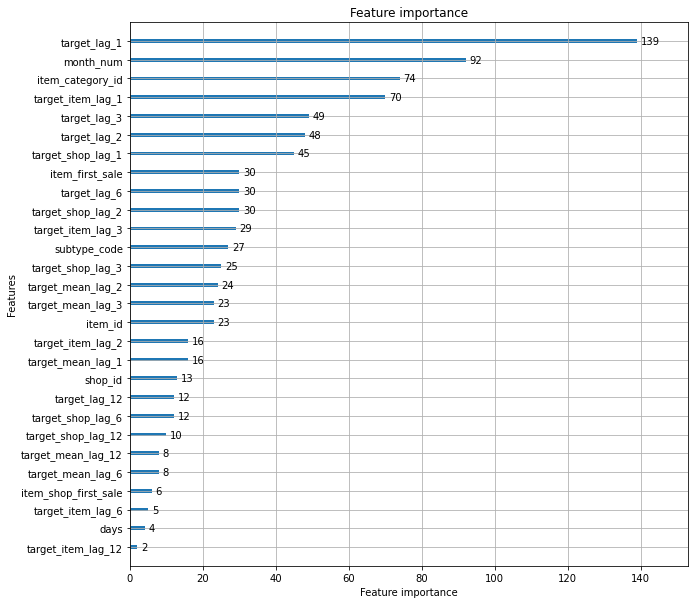

In [34]:
# Plot LightGBM features importance
from lightgbm import plot_importance
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1,1,figsize=(10, 10))
plot_importance(booster=model_lgb, ax=ax)